##### Solutia a 2 a embeddings


In solutia 2 am abordat o clasificarea printr un model bazat pe similaritate semantica. Obiectivul a fost sa depasesc limitele regulilor exacte din solutia 1 si sa surprind sensul real al descrierilor companiilor. Am implementat o metoda hibrida TF-IDF si Similaritate Cosinus, cu optiune de extindere la embeddings din modele mari de limbaj (llm) precum sentence-transformers.

Ideea de baza a fost urmatoarea: daca o companie are o descriere textuala similara semantic cu descrierea unei etichete din taxonomie, atunci compania trebuie clasificata cu acea eticheta. In loc sa cautam potriviri exacte intre cuvinte, cautam proximitate semantica intre texte.

Am ales TF-IDF deoarece ofera o reprezentare interpretabila, rapida si scalabila. Fiecare text este transformat intr un vector de importante relative ale cuvintelor. Cu ajutorul similaritatii cosinus putem masura cat de apropiate sunt vectorial descrierile companiilor de definitiile etichetelor.

Pentru a imbunatati semnalul, am concatenat trei surse de informatie: Description, Business Tags si Sector. Am curatat textul (lowercase, eliminare semne non-alfanumerice, stopwords, spatii multiple). Astfel am construit un camp text complet pentru fiecare companie si fiecare eticheta.

Apoi am calculat scorurile de similaritate intre fiecare companie si fiecare eticheta. Scorurile mari semnifica asemanare semantica puternica. Am ales praguri dinamice bazate pe distributia scorurilor, media plus o deviatie standard. Fiecare companie a primit una sau mai multe etichete cu scor peste prag.

Am considerat si alternativa embeddings, cu all-minilm-l6-v2, care capteaza semnificatia contextuala. Tf idf masoara similaritate lexica, dar embeddings masoara similaritate conceptuala. Am evaluat ambele pentru comparatie.

Avantajul principal al acestei abordari este adaptabilitatea. Nu depinde strict de seeduri. Daca o companie mentioneaza "automobile" iar taxonomia contine "vehicle insurance", modelul de embeddings poate detecta asemanarea fara sa fie explicit mentionat termenul.

Am optat pentru aceasta metoda deoarece se extinde natural la sute de etichete si mii de companii. Computarea similaritatii cosinus intre matrice tf-idf este eficienta. Putem scala pe gpu pentru embeddings sau ramane pe cpu pentru tf-idf. Sistemul permite actualizare rapida: adaugam o eticheta noua, recalculam doar vectorii ei. 

In concluzie solutia 2 ofera un echilibru intre flexibilitate si explicabilitate. Modelul poate descoperi conexiuni semantice imposibil de capturat prin reguli fixe. Functioneaza bine pe descrieri variate, sinonime si texte incomplete.

Ca si limitari tf-idf ignora ordinea cuvintelor si contextul. Doua texte cu aceleasi cuvinte in ordine diferita pot avea scor mare desi sensul difera. Lipsa de ground truth real face validarea indirecta. Modelul depinde de calitatea textelor. Descrieri scurte, zgomotoase sau neinformative reduc acuratetea. 

Pentru analiza calitativa, putem lista top 20 companii cu scoruri ambigue sau multiple etichete. Aceasta ajuta la rafinarea descrierilor etichetelor din taxonomie. Scalabilitatea este ridicata. Tf idf + cosine se ruleaza eficient pe zeci de mii de companii. Cu embeddings si faiss, putem scala la milioane. Sistemul este complet offline si reproductibil. Per total solutia 2 este mai buna si un pas major ca prima pentru ca captam sensul nu doar potrivirea literala. Rezultatele sunt mai bogate si utile pentru descoperire de pattern uri si extinderea taxonomiei. Cu validare manuala pe un subset de 300 companii putem calibra pragurile si masura f1 macro, recall pe label si average precision.





In [1]:
import re
from pathlib import Path
import json
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity




In [2]:

tax_path = Path('insurance_taxonomy_label.csv')
comp_path = Path('insurances_company_list.csv')
output_prefix = Path('s2/sol2_tfidf')

assert tax_path.exists(), f"Taxonomy file not found: {tax_path}"
assert comp_path.exists(), f"Companies file not found: {comp_path}"

tax_df = pd.read_csv(tax_path)
comp_df = pd.read_csv(comp_path)

# afisare scurta
print("Taxonomy rows:", len(tax_df))
print("Companies rows:", len(comp_df))
tax_df.head(5)

Taxonomy rows: 220
Companies rows: 9494


,label
0,Agricultural Equipment Services
1,Soil Nutrient Application Services
2,Pesticide Application Services
3,Ornamental Plant Nurseries
4,Landscaping Services


In [3]:
def clean_text(s):
    if pd.isna(s) or s is None:
        return ''
    s = str(s).lower()
    s = s.replace('ă','a').replace('â','a').replace('î','i').replace('ș','s').replace('ş','s').replace('ț','t').replace('ţ','t')
    s = re.sub(r'[^a-z0-9\s\-]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [4]:
if 'label' not in tax_df.columns:
    tax_df = tax_df.rename(columns={tax_df.columns[0]: 'label'})
if 'seeds' not in tax_df.columns:
    tax_df['seeds'] = ''

label_texts = {}
for _, r in tax_df.iterrows():
    label = str(r['label']).strip()
    seeds = str(r.get('seeds','') or '')
    if seeds.strip():
        parts = [clean_text(p) for p in seeds.split('|') if p.strip()]  # seeds separate prin |
        doc = ' '.join(parts)
    else:
        parts = [clean_text(w) for w in re.split(r'[\s\-_]+', label) if len(w)>=2]
        doc = ' '.join(parts) if parts else clean_text(label)
    label_texts[label] = doc

# check/verificare
list(label_texts.items())[:6]

[('Agricultural Equipment Services', 'agricultural equipment services'),
 ('Soil Nutrient Application Services', 'soil nutrient application services'),
 ('Pesticide Application Services', 'pesticide application services'),
 ('Ornamental Plant Nurseries', 'ornamental plant nurseries'),
 ('Landscaping Services', 'landscaping services'),
 ('Gardening Services', 'gardening services')]

In [5]:
cols = [c.lower() for c in comp_df.columns]
name_col = next((c for c in comp_df.columns if 'name' in c.lower()), comp_df.columns[0])
desc_col = next((c for c in comp_df.columns if 'description' in c.lower()), None)
tags_col = next((c for c in comp_df.columns if 'tag' in c.lower()), None)
sector_col = next((c for c in comp_df.columns if 'sector' in c.lower()), None)

# fallbackuri
if desc_col is None:
    desc_col = comp_df.columns[1] if comp_df.shape[1] > 1 else name_col
if tags_col is None:
    tags_col = desc_col
if sector_col is None:
    sector_col = ''

# concatenare si curatare
def compose_company_text(row):
    parts = []
    if desc_col and pd.notna(row.get(desc_col,'')):
        parts.append(str(row.get(desc_col,'')))
    if tags_col and pd.notna(row.get(tags_col,'')):
        parts.append(str(row.get(tags_col,'')))
    if sector_col and sector_col in comp_df.columns and pd.notna(row.get(sector_col,'')):
        parts.append(str(row.get(sector_col,'')))
    text = ' '.join(parts)
    return clean_text(text)

comp_df['_text'] = comp_df.apply(compose_company_text, axis=1)
print("Exemplu text companii:")
comp_df[[_text := '_text', name_col]].head(5)

Exemplu text companii:


,_text,description
0,welchcivils is a civil engineering and constru...,Welchcivils is a civil engineering and constru...
1,kyoto vegetable specialists uekamo also known ...,"Kyoto Vegetable Specialists Uekamo, also known..."
2,loidholdhof integrative hofgemeinschaft is a c...,Loidholdhof Integrative Hofgemeinschaft is a c...
3,patagonia chapa y pintura is an auto body shop...,PATAGONIA Chapa Y Pintura is an auto body shop...
4,stanica wodna pttk swornegacie is a cultural e...,Stanica WODNA PTTK Swornegacie is a cultural e...


In [6]:
# Construire corpus TF-IDF etichete + companii

labels = list(label_texts.keys())
label_docs = [label_texts[l] for l in labels]

company_docs = comp_df['_text'].fillna('').tolist()
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=50000) # Vectorizator TF-IDF
all_docs = label_docs + company_docs
tfidf.fit(all_docs) # fit pe ambele pentru acelasi spatiu

# transform
label_vecs = tfidf.transform(label_docs) 
company_vecs = tfidf.transform(company_docs)

print("Label vectors:", label_vecs.shape)
print("Company vectors:", company_vecs.shape)

Label vectors: (220, 50000)
Company vectors: (9494, 50000)


In [7]:
sim_matrix = cosine_similarity(company_vecs, label_vecs)
sim_matrix.shape

(9494, 220)

In [8]:
# Alegere praguri per eticheta

label_means = sim_matrix.mean(axis=0)
label_stds = sim_matrix.std(axis=0)
thresholds_meanstd = label_means + label_stds

global_fixed_threshold = 0.18 # alternativ prag fix minimal fallback

thresholds = {labels[i]: float(max(thresholds_meanstd[i], global_fixed_threshold)) for i in range(len(labels))} # alege prag final per eticheta

# afisare prime 10 praguri
list(thresholds.items())[:10]

[('Agricultural Equipment Services', 0.18),
 ('Soil Nutrient Application Services', 0.18),
 ('Pesticide Application Services', 0.18),
 ('Ornamental Plant Nurseries', 0.18),
 ('Landscaping Services', 0.18),
 ('Gardening Services', 0.18),
 ('Tree Services - Pruning / Removal', 0.18),
 ('Veterinary Services', 0.18),
 ('Veterinary Clinics', 0.18),
 ('Pet Boarding Services', 0.18)]

In [9]:
# Atribuim multi-label pe baza pragurilor

assigned = []
assigned_scores = []
for i in range(sim_matrix.shape[0]):
    row = sim_matrix[i]
    labs = []
    labs_scores = {}
    for j, lab in enumerate(labels):
        score = float(row[j])
        if score >= thresholds[lab]:
            labs.append(lab)
            labs_scores[lab] = score
    assigned.append(labs)
    assigned_scores.append(labs_scores)

comp_df['assigned_tf_idf'] = assigned
comp_df['assigned_tf_idf_scores'] = assigned_scores

# statistici rapide
n_companies = len(comp_df)
n_assigned_any = sum(1 for a in assigned if a)
print("Companii :", n_companies)
print("Companii cu cel putin o eticheta :", n_assigned_any)
Counter([l for labs in assigned for l in labs]).most_common(15)

Companii : 9494
Companii cu cel putin o eticheta : 1971


[('Real Estate Services', 73),
 ('Consulting Services', 68),
 ('Insurance Services', 55),
 ('Non-Profit Management', 54),
 ('Printing Services', 53),
 ('Waste Management Services', 53),
 ('Furniture Manufacturing', 49),
 ('Sports Management Services', 47),
 ('Boiler Repair Services', 46),
 ('Well Maintenance Services', 46),
 ('Financial Services', 44),
 ('Interior Design Services', 43),
 ('Masonry Construction Services', 43),
 ('Fencing Construction Services', 40),
 ('Software Development Services', 39)]

In [10]:
# Salvare rezultate si fisiere

output_dir = Path('s2')
output_dir.mkdir(parents=True, exist_ok=True)

output_prefix = output_dir / 'sol2_tfidf'

comp_df.to_csv(f"{output_prefix}.csv", index=False) # csv

with open(f"{output_prefix}_labels.json", 'w', encoding='utf-8') as f:
    json.dump({'labels': labels, 'thresholds': thresholds}, f, ensure_ascii=False, indent=2) # JSON labels

with open(f"{output_prefix}_summary.json", 'w', encoding='utf-8') as f:
    summary = {
        'n_companies': int(n_companies),
        'n_assigned_any': int(n_assigned_any),
        'top_labels': Counter([l for labs in assigned for l in labs]).most_common(30)
    }
    json.dump(summary, f, ensure_ascii=False, indent=2) #JSON summary

print("Saved in folder:", output_dir)
print(" -", f"{output_prefix}.csv")
print(" -", f"{output_prefix}_labels.json")
print(" -", f"{output_prefix}_summary.json")

Saved in folder: s2
 - s2\sol2_tfidf.csv
 - s2\sol2_tfidf_labels.json
 - s2\sol2_tfidf_summary.json


In [11]:
# Cautam o coloana true_labels sau ground_truth in comp_df
possible_truth_cols = [c for c in comp_df.columns if 'true' in c.lower() or 'ground' in c.lower() or 'label' in c.lower()]
possible_truth_cols[:6]


[]

In [12]:
if 'true_labels' in comp_df.columns or any('true' in c.lower() for c in comp_df.columns):
    truth_col = 'true_labels' if 'true_labels' in comp_df.columns else next(c for c in comp_df.columns if 'true' in c.lower())
    def parse_truth(s):
        if pd.isna(s) or s=='':
            return []
        if isinstance(s, list):
            return s
        
        parts = re.split(r'[;,|]', str(s))
        return [p.strip() for p in parts if p.strip()]
    comp_df['_truth_list'] = comp_df[truth_col].apply(parse_truth)
    

    from sklearn.preprocessing import MultiLabelBinarizer # construire ml binarizer simplu

    mlb = MultiLabelBinarizer(classes=labels)
    Y_true = mlb.fit_transform(comp_df['_truth_list'])
    Y_pred = mlb.transform(comp_df['assigned_tf_idf'])
    
    from sklearn.metrics import classification_report

    print(classification_report(Y_true, Y_pred, target_names=mlb.classes_, zero_division=0))
else:
    print("Nu am gasit coloana ground truth. Daca ai, redenumeste in 'true_labels' sau adauga o coloana similara.")

Nu am gasit coloana ground truth. Daca ai, redenumeste in 'true_labels' sau adauga o coloana similara.


In [ ]:
import warnings, os
warnings.filterwarnings("ignore")
os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_TF_WARNING"] = "1"

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

# scazut batch size pentru ca dura prea mult 
label_emb = model.encode(label_docs, show_progress_bar=False, batch_size=16, convert_to_numpy=True)
comp_emb = model.encode(company_docs, show_progress_bar=False, batch_size=16, convert_to_numpy=True)

print("Label embeddings:", label_emb.shape)
print("Company embeddings:", comp_emb.shape)


Label embeddings: (220, 384)
Company embeddings: (9494, 384)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


batch_size = 500   
sim_matrix_emb = np.zeros((len(comp_emb), len(label_emb)), dtype=np.float32)

for start in tqdm(range(0, len(comp_emb), batch_size), desc="Calcul cosine batches"):
    end = min(start + batch_size, len(comp_emb))
    sim_matrix_emb[start:end] = cosine_similarity(comp_emb[start:end], label_emb)

print("Shape matrice similaritate:", sim_matrix_emb.shape)


Calcul cosine batches: 100%|██████████| 19/19 [00:00<00:00, 483.53it/s]

Shape matrice similaritate: (9494, 220)


In [15]:
# praguri dinamice mean + std
label_means_emb = sim_matrix_emb.mean(axis=0)
label_stds_emb = sim_matrix_emb.std(axis=0)
thresholds_meanstd_emb = label_means_emb + label_stds_emb

global_fixed_threshold_emb = 0.40
thresholds_emb = {
    labels[i]: float(max(thresholds_meanstd_emb[i], global_fixed_threshold_emb))
    for i in range(len(labels))
}

assigned_emb, assigned_scores_emb = [], []
for i, row in enumerate(sim_matrix_emb):
    labs, labs_scores = [], {}
    for j, lab in enumerate(labels):
        score = float(row[j])
        if score >= thresholds_emb[lab]:
            labs.append(lab)
            labs_scores[lab] = score
    assigned_emb.append(labs)
    assigned_scores_emb.append(labs_scores)

comp_df['assigned_emb'] = assigned_emb
comp_df['assigned_emb_scores'] = assigned_scores_emb

print("Companii procesate:", len(comp_df))
print("Companii cu cel putin o eticheta:", sum(1 for a in assigned_emb if a))


Companii procesate: 9494
Companii cu cel putin o eticheta: 4785


In [16]:
for i, row in comp_df.head(5).iterrows():
    print(f"{i+1}. {row[name_col]}")
    print("   Etichete:", row['assigned_emb'])
    print("   Scoruri:", {k: round(v, 3) for k, v in row['assigned_emb_scores'].items()})
    print()


1. Welchcivils is a civil engineering and construction company that specializes in designing and building utility network connections across the UK. They offer multi-utility solutions that combine electricity, gas, water, and fibre optic installation into a single contract. Their design engineer teams are capable of designing electricity, water and gas networks from existing network connection points to meter locations at the development, as well as project management of reinforcements and diversions. They provide custom connection solutions that take into account any existing assets, maximize the usage of every trench, and meet project deadlines. Welchcivils has considerable expertise installing gas and electricity connections in a variety of market categories, including residential, commercial, and industrial projects, as as well.
   Etichete: ['Commercial Communication Equipment Installation', 'Residential Plumbing Services', 'Commercial Plumbing Services', 'Industrial Plumbing Serv

In [17]:
comp_sample = company_docs[:200]
comp_emb = model.encode(comp_sample, batch_size=16, show_progress_bar=True)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [18]:
np.save("s2/embeddings_sim_matrix_emb.npy", sim_matrix_emb)


In [19]:


output_dir = Path('s2')
output_dir.mkdir(parents=True, exist_ok=True)

output_prefix = output_dir / 'sol2_embeddings'


comp_df.to_csv(f"{output_prefix}.csv", index=False) # Salvam CSV complet


with open(f"{output_prefix}_labels.json", 'w', encoding='utf-8') as f:
    json.dump({'labels': labels, 'thresholds': thresholds_emb}, f, ensure_ascii=False, indent=2)

summary_emb = {
    'n_companies': int(len(comp_df)),
    'n_assigned_any': int(sum(1 for a in assigned_emb if a)),
    'top_labels': Counter([l for labs in assigned_emb for l in labs]).most_common(30)
}

with open(f"{output_prefix}_summary.json", 'w', encoding='utf-8') as f:
    json.dump(summary_emb, f, ensure_ascii=False, indent=2)

print("Saved embeddings results in folder:", output_dir)
print(" -", f"{output_prefix}.csv")
print(" -", f"{output_prefix}_labels.json")
print(" -", f"{output_prefix}_summary.json")


Saved embeddings results in folder: s2
 - s2\sol2_embeddings.csv
 - s2\sol2_embeddings_labels.json
 - s2\sol2_embeddings_summary.json


In [20]:
# Comparare rezultate TF-IDF vs Embeddings

def compare_label_sets(tfidf_labels, emb_labels):
    tfidf_set = set(tfidf_labels)
    emb_set = set(emb_labels)
    intersect = tfidf_set & emb_set
    only_tfidf = tfidf_set - emb_set
    only_emb = emb_set - tfidf_set
    return {
        "common": list(intersect),
        "only_tfidf": list(only_tfidf),
        "only_emb": list(only_emb)
    }

comparison = []
for i, row in comp_df.iterrows():
    res = compare_label_sets(row['assigned_tf_idf'], row['assigned_emb'])
    comparison.append(res)

comp_df['label_overlap'] = [r['common'] for r in comparison]
comp_df['only_tfidf'] = [r['only_tfidf'] for r in comparison]
comp_df['only_emb'] = [r['only_emb'] for r in comparison]

print("Comparatie etichete intre TF-IDF si Embeddings completata.")


Comparatie etichete intre TF-IDF si Embeddings completata.


In [21]:
# Analiza intre ele 

same_labels = sum(1 for r in comp_df['label_overlap'] if len(r) > 0)
only_tfidf_count = sum(1 for r in comp_df['only_tfidf'] if len(r) > 0)
only_emb_count = sum(1 for r in comp_df['only_emb'] if len(r) > 0)

print(f"Companii cu etichete comune intre TF-IDF si Embeddings: {same_labels}")
print(f"Companii etichetate doar de TF-IDF: {only_tfidf_count}")
print(f"Companii etichetate doar de Embeddings: {only_emb_count}")

from collections import Counter

overlap_labels = Counter([lab for labs in comp_df['label_overlap'] for lab in labs])
print("\nTop 10 etichete comune intre metode:")
for lab, count in overlap_labels.most_common(10):
    print(f" - {lab}: {count} companii")


Companii cu etichete comune intre TF-IDF si Embeddings: 1134
Companii etichetate doar de TF-IDF: 1042
Companii etichetate doar de Embeddings: 4413

Top 10 etichete comune intre metode:
 - Furniture Manufacturing: 44 companii
 - Waste Management Services: 38 companii
 - Insurance Services: 37 companii
 - Printing Services: 35 companii
 - Consulting Services: 33 companii
 - Interior Design Services: 28 companii
 - Real Estate Services: 28 companii
 - Plastic Manufacturing: 23 companii
 - Recycling Services: 21 companii
 - Rubber Manufacturing: 21 companii


In [22]:
print("Exemple comparative TF-IDF vs Embeddings:\n")

for i, row in comp_df.head(5).iterrows():
    print(f"{i+1}. {row[name_col]}")
    print("   TF-IDF:", row['assigned_tf_idf'])
    print("   EMBEDDINGS:", row['assigned_emb'])
    print("   COMUNE:", row['label_overlap'])
    print()


Exemple comparative TF-IDF vs Embeddings:

1. Welchcivils is a civil engineering and construction company that specializes in designing and building utility network connections across the UK. They offer multi-utility solutions that combine electricity, gas, water, and fibre optic installation into a single contract. Their design engineer teams are capable of designing electricity, water and gas networks from existing network connection points to meter locations at the development, as well as project management of reinforcements and diversions. They provide custom connection solutions that take into account any existing assets, maximize the usage of every trench, and meet project deadlines. Welchcivils has considerable expertise installing gas and electricity connections in a variety of market categories, including residential, commercial, and industrial projects, as as well.
   TF-IDF: []
   EMBEDDINGS: ['Commercial Communication Equipment Installation', 'Residential Plumbing Services'

In [23]:
print("Analiza comparativa TF-IDF vs Embeddings:")
print("- TF-IDF capteaza potriviri lexicale exacte (utile pentru denumiri tehnice).")
print("- Embeddings captureaza semantica contextuala (utile cand descrierile sunt scurte sau sinonime).")
print("- Intersectia dintre cele doua metode reprezinta clasificari robuste, cu probabilitate mare de corectitudine.")
print("- Diferentele pot fi folosite pentru re-etalonare a pragurilor per eticheta.")
print("- Pentru productivizare, se recomanda combinarea scorurilor (ex: media normalizata TF-IDF + Embedding).")


Analiza comparativa TF-IDF vs Embeddings:
- TF-IDF capteaza potriviri lexicale exacte (utile pentru denumiri tehnice).
- Embeddings captureaza semantica contextuala (utile cand descrierile sunt scurte sau sinonime).
- Intersectia dintre cele doua metode reprezinta clasificari robuste, cu probabilitate mare de corectitudine.
- Diferentele pot fi folosite pentru re-etalonare a pragurilor per eticheta.
- Pentru productivizare, se recomanda combinarea scorurilor (ex: media normalizata TF-IDF + Embedding).


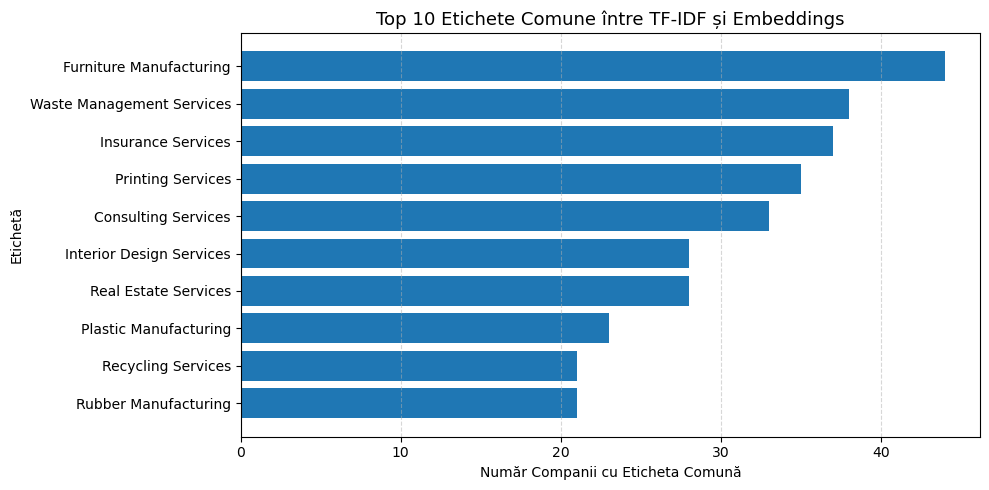

In [25]:
# Calculam frecventele etichetelor comune
overlap_labels = Counter([lab for labs in comp_df['label_overlap'] for lab in labs])

# Selectam top 10 etichete comune
top_common_labels = overlap_labels.most_common(10)
labels_top = [x[0] for x in top_common_labels]
counts_top = [x[1] for x in top_common_labels]

import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 5))
plt.barh(labels_top[::-1], counts_top[::-1])
plt.title("Top 10 Etichete Comune între TF-IDF și Embeddings", fontsize=13)
plt.xlabel("Număr Companii cu Eticheta Comună")
plt.ylabel("Etichetă")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


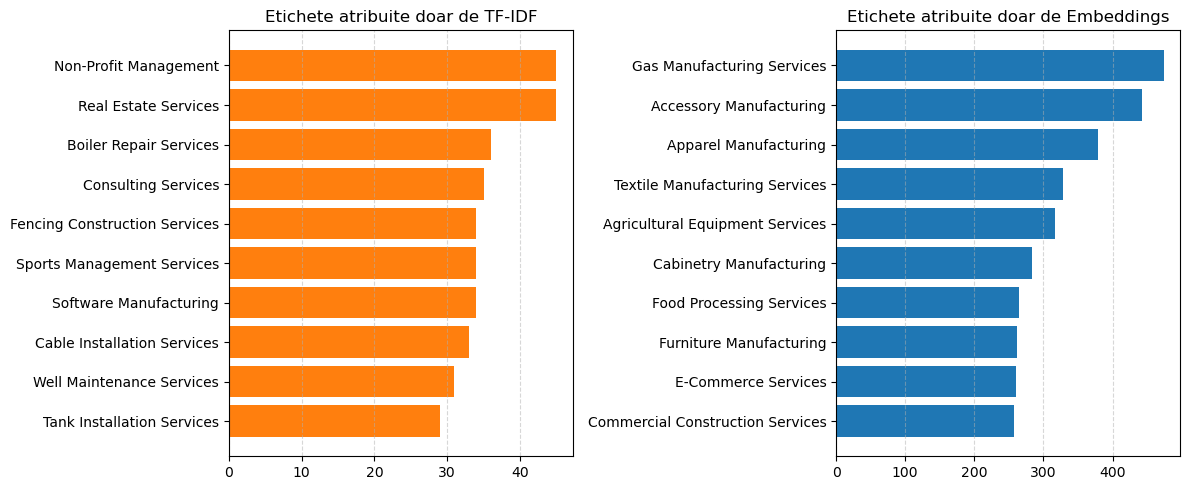

In [26]:
# Etichete atribuite doar de TF-IDF sau doar de Embeddings
only_tfidf_labels = Counter([lab for labs in comp_df['only_tfidf'] for lab in labs])
only_emb_labels = Counter([lab for labs in comp_df['only_emb'] for lab in labs])

# Top 10 divergente
top_tfidf_unique = only_tfidf_labels.most_common(10)
top_emb_unique = only_emb_labels.most_common(10)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# tfidf
ax[0].barh([x[0] for x in top_tfidf_unique[::-1]], [x[1] for x in top_tfidf_unique[::-1]], color='tab:orange')
ax[0].set_title("Etichete atribuite doar de TF-IDF", fontsize=12)
ax[0].grid(axis='x', linestyle='--', alpha=0.5)

# embeddings
ax[1].barh([x[0] for x in top_emb_unique[::-1]], [x[1] for x in top_emb_unique[::-1]], color='tab:blue')
ax[1].set_title("Etichete atribuite doar de Embeddings", fontsize=12)
ax[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
